In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.preprocessing import StandardScaler

In [22]:
df = pd.read_csv('C:\\Users\\shakt\\Downloads\\playground\\csv_corner\\data\\data.csv')

In [23]:
df.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


In [24]:
df.shape

(1000000, 81)

In [25]:
df = df[['F_1_0', 'F_1_1']]

In [26]:
df.isna().sum()

F_1_0    18397
F_1_1    18216
dtype: int64

In [27]:
type(df)

pandas.core.frame.DataFrame

In [60]:
scaler = StandardScaler()
train_data = scaler.fit_transform(df)#.drop('row_id', axis = 1))

In [72]:
BUFFER_SIZE = 900000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [73]:
def generator_builder(num_fet = 2):
    
  # 80 * 2 = 162
    generator = keras.models.Sequential([
    keras.layers.Input(shape = num_fet * 2), 
    keras.layers.Dense(150, 'relu'),
    keras.layers.Dense(100, 'relu'),
    keras.layers.Dense(2, 'sigmoid')
  ])
    return generator

In [74]:
def discriminator_builder(num_fet = 2):
    
  # 80 * 2 = 162
    discriminator = keras.models.Sequential([
    keras.layers.Input(shape = num_fet * 2),
    keras.layers.Dense(150, 'relu'),
    keras.layers.Dense(100, 'relu'),
    keras.layers.Dense(2, 'sigmoid'),
  ])

    return discriminator

In [75]:
def discriminator_loss(m, m_hat):
    temp = tf.math.multiply(m, tf.math.log(m_hat + 1e-8))
    temp += tf.math.multiply(tf.ones_like(m) - m , tf.math.log(tf.ones_like(m_hat) - m_hat + 1e-8))
    return -tf.reduce_mean(temp)

In [76]:
def generator_loss(m, m_hat, x, x_hat, alpha = 10):
    loss = -tf.math.multiply((tf.ones_like(m)-m), tf.math.log(m_hat+1e-8))
    loss += alpha * tf.multiply(m, (x - x_hat) ** 2)
    return tf.reduce_mean(loss)

In [77]:
def hint_smapler(batch_size = 128, num_fet = 2, hint_rate = 0.9):
    A = np.random.uniform(0., 1., size = [batch_size, num_fet])
    B = hint_rate > A
    C = 1.*B
    return C

In [78]:
generator_optimizer = keras.optimizers.SGD(1e-4)
discriminator_optimizer = keras.optimizers.SGD(1e-4)

In [79]:
generator = generator_builder()
discriminator = discriminator_builder()

In [80]:
@tf.function
def train_step(batch, epoch_num):
     
    m = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), tf.ones_like(batch))
    batch_C = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), batch)
    z = np.random.uniform(0, 0.01, size = batch.shape)
    batch = tf.math.multiply(batch_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        X_temp = tf.cast(generator(tf.concat([batch, m], 1), training = True), tf.float64)
        X_hat = tf.math.multiply(m, batch) + tf.math.multiply((tf.ones_like(m) - m), X_temp)

        H = tf.math.multiply(hint_smapler(),  m)
        M_hat = tf.cast(discriminator(tf.concat([X_hat, H], 1), training = True), tf.float64)

        disc_loss = discriminator_loss(m, M_hat)
        gen_loss = generator_loss(m, M_hat, batch, X_hat, alpha = 10)

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients((zip(disc_grad, discriminator.trainable_variables)))
    return gen_loss, disc_loss

In [81]:
def train(dataset, EPOCHS):
    losses_gen = []
    losses_disc  = []
    for epoch in range(1, EPOCHS+1):
        print(f'Epoch {epoch} / {EPOCHS}:', end=' ')
        t0 = time.time()
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch, epoch)
            losses_gen.append(gen_loss)
            losses_disc.append(disc_loss)
        t1 = time.time()
        print(f'gen_loss = {gen_loss}, disc_loss = {disc_loss}, time = {t1 - t0}')
    return losses_gen, losses_disc

In [82]:
gen_loss, disc_loss = train(train_dataset, EPOCHS = 10)

Epoch 1 / 10: gen_loss = 0.00999752461512054, disc_loss = 0.43263311279806993, time = 61.49548840522766
Epoch 2 / 10: gen_loss = 0.007188809819797987, disc_loss = 0.2552474802069849, time = 48.97811985015869
Epoch 3 / 10: gen_loss = 0.0030872797375017845, disc_loss = 0.14757623328862907, time = 55.83589053153992
Epoch 4 / 10: gen_loss = 0.0025184686546911904, disc_loss = 0.10592938958993495, time = 38.49400568008423
Epoch 5 / 10: gen_loss = 0.00416928489435388, disc_loss = 0.14504506596088823, time = 39.88294792175293
Epoch 6 / 10: gen_loss = 0.001824045219274675, disc_loss = 0.07433178363854938, time = 39.771244287490845
Epoch 7 / 10: gen_loss = 0.0005822959045297458, disc_loss = 0.05420848896186601, time = 54.736079931259155
Epoch 8 / 10: gen_loss = 0.0027265945352339467, disc_loss = 0.10943112712692485, time = 45.91832613945007
Epoch 9 / 10: gen_loss = 0.0024296197792368114, disc_loss = 0.12411238537381686, time = 52.899868965148926
Epoch 10 / 10: gen_loss = 0.002154284913212338, di

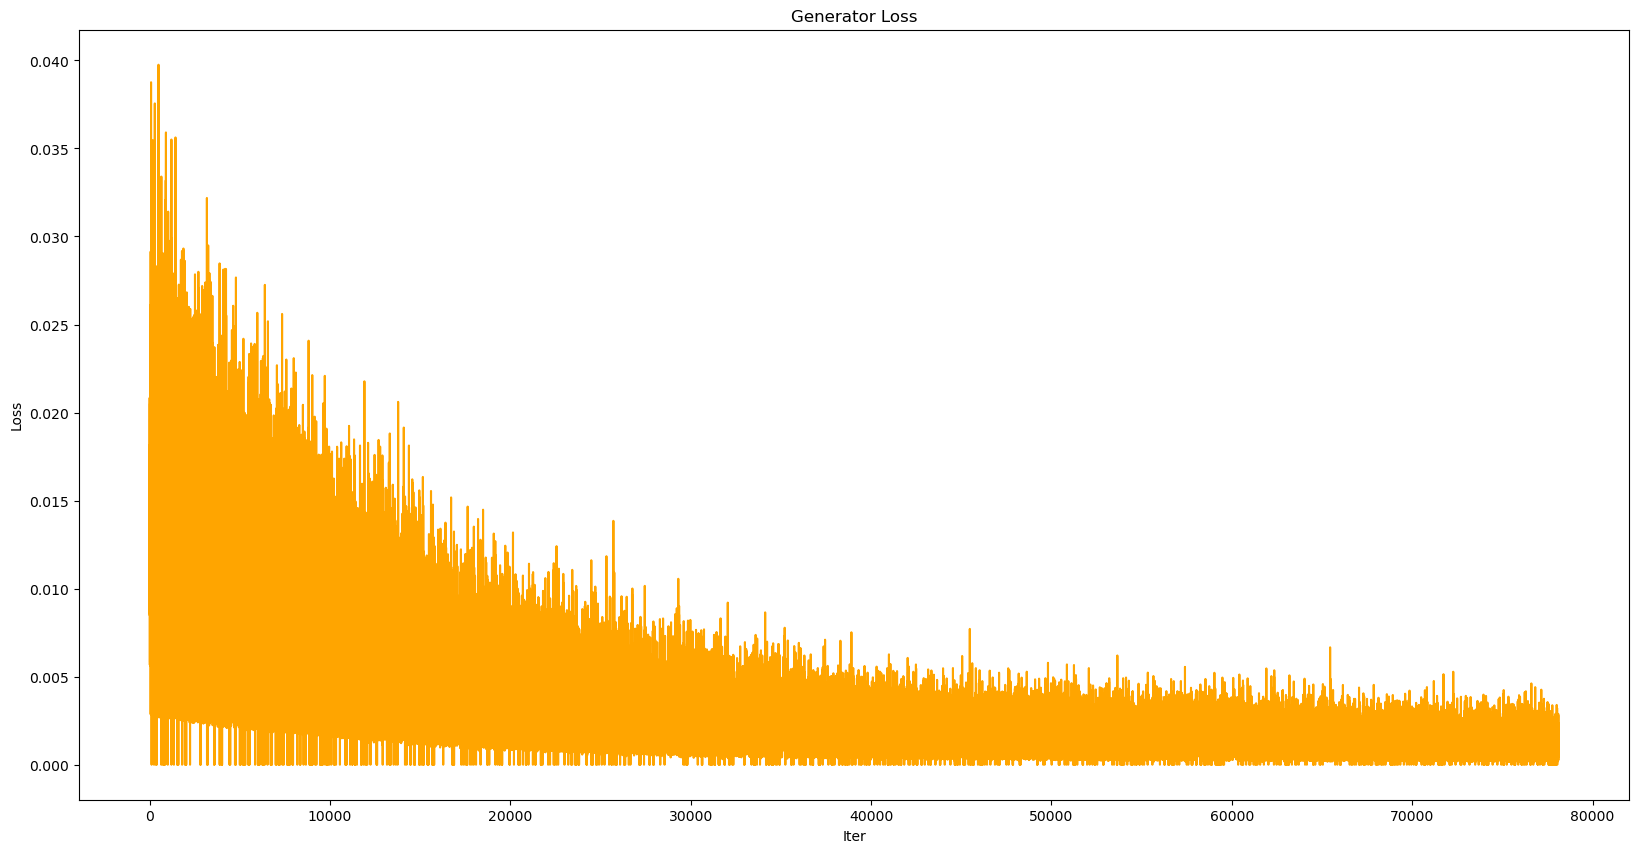

In [83]:
plt.figure(figsize = (20, 10))
plt.plot(gen_loss, color = 'orange')
plt.title('Generator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

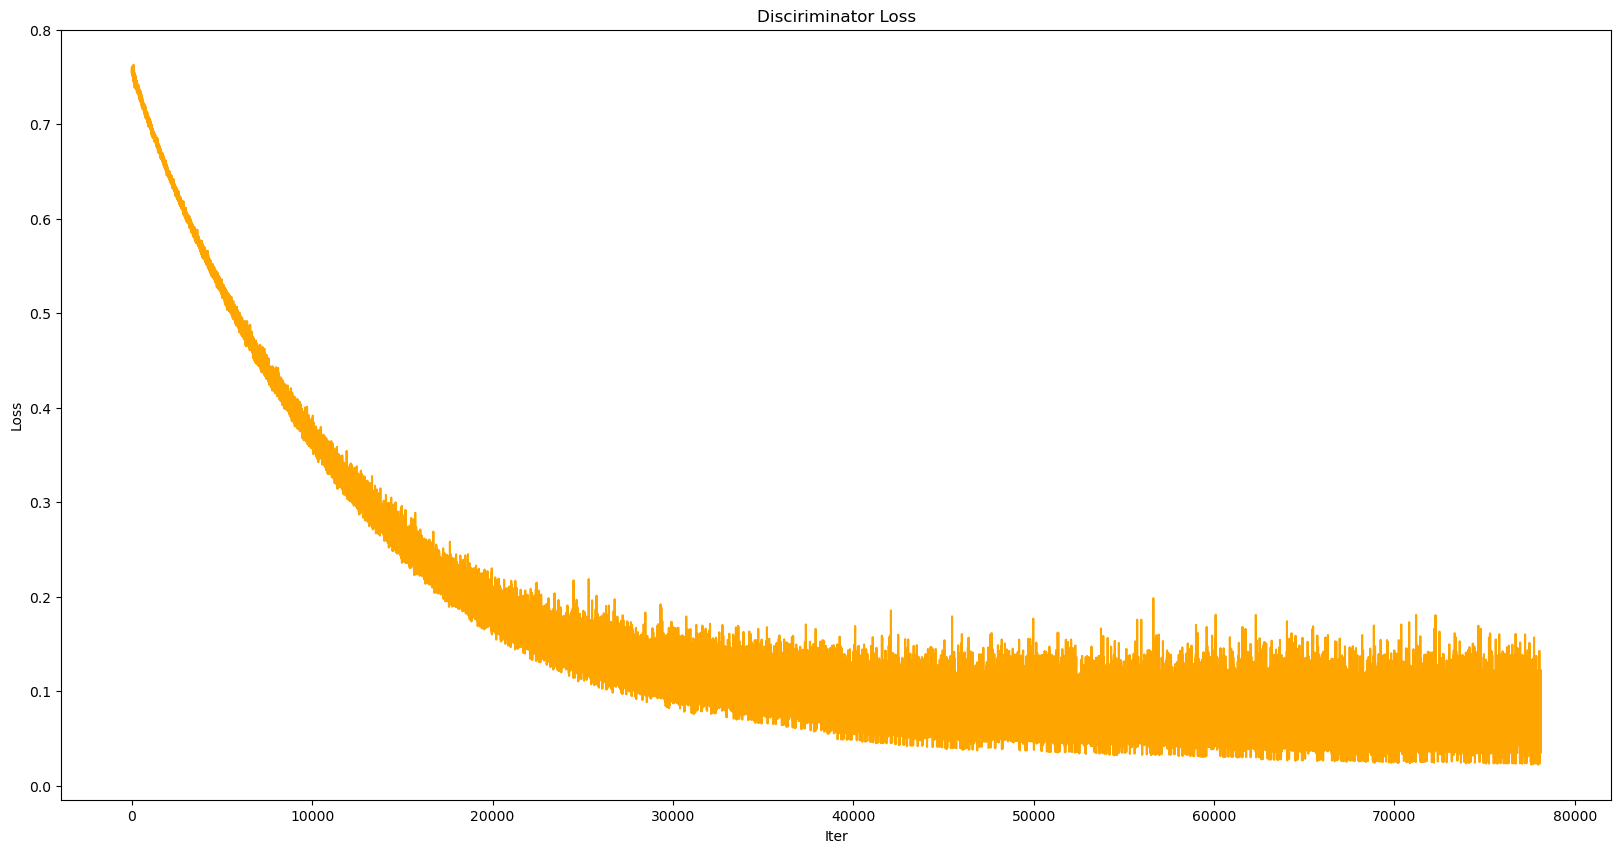

In [84]:
plt.figure(figsize = (20, 10))
plt.plot(disc_loss, color = 'orange')
plt.title('Disciriminator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [85]:
m = tf.where(tf.math.is_nan(train_data), tf.zeros_like(train_data), tf.ones_like(train_data))
train_data_C = tf.where(tf.math.is_nan(train_data), tf.zeros_like(train_data), train_data)
z = np.random.uniform(0, 0.01, size = train_data.shape)
train_data = tf.math.multiply(train_data_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)

In [86]:
X_temp = tf.cast(generator(tf.concat([train_data, m], 1), training = True), tf.float64)
X_hat = tf.math.multiply(m, train_data) + tf.math.multiply((tf.ones_like(m) - m), X_temp) 

In [88]:
pred = scaler.inverse_transform(X_hat)
df_ = df#.drop(['row_id'], axis = 1)
test = []
for idx_col, col in enumerate(df):
    for idx_row, row in enumerate(df.loc[:, col]):
        if np.isnan(row):
            test.append(f'{idx_row}-{col}')
res = []
for col_idx, col in enumerate(df_):
    for row_idx, row in enumerate(df_.loc[:, col]):
        if np.isnan(row):
            res.append(pred[row_idx, col_idx])

In [89]:
out = np.array([test, res])
out = pd.DataFrame(out.T)
out = out.rename({0: 'row-col', 1: 'value'}, axis = 1)
out.to_csv('sub3_temp.csv', index = False)

In [90]:
out.head()

,row-col,value
0,21-F_1_0,0.46236643895818186
1,128-F_1_0,0.4315307179472188
2,182-F_1_0,0.48884972910882096
3,191-F_1_0,0.48660543657651556
4,289-F_1_0,0.48968287950149336


In [91]:
df.head()

,F_1_0,F_1_1
0,-0.354591,-0.464038
1,1.380940,-0.499626
2,0.256023,-1.059874
3,-0.728420,-2.432399
4,0.590212,-0.066127


In [104]:
df.iloc[180:183]

,F_1_0,F_1_1
180,0.135725,-0.136011
181,0.339243,1.432538
182,NaN,-1.528396


In [103]:
out.iloc[126:129]

,row-col,value
126,6869-F_1_0,0.4344480566512521
127,6937-F_1_0,0.4463726595901204
128,6977-F_1_0,0.4892597724824323
